# 02 Fine Tuning BERT

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
from IPython.display import Image

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.base import BaseEstimator

import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score, f1_score

from transformers import BertForSequenceClassification, BertTokenizerFast

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as torch_optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from imbalanced import ImbalancedDatasetSampler

### Load Dataset

In [2]:
regex_str = re.compile(r"(.+?),(About|None),(article_.+?),(.*)") 

df_row_list = []
f_in = open ('dataset/aboutlabeled.csv', 'r')
for i, line in enumerate(f_in):
    if i > 0:
        r_match = re.match(regex_str, line)
        df_row = [r_match[1], r_match[2], r_match[3], r_match[4]]
        df_row_list.append(df_row)
f_in.close()      

df = pd.DataFrame(df_row_list)
df.columns = ['Text', 'Label', 'ID', 'Offsets']

### Encode y

In [3]:
df.loc[df['Label'] == 'None', 'Label'] = 0
df.loc[df['Label'] == 'About', 'Label'] = 1
df['Label'] = df['Label'].astype(int)

### Drop uninformative columns. I don't go deep into "Offsets", because DL model will do it.

In [4]:
df.drop(['ID', 'Offsets'], axis=1, inplace=True)
df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16721 entries, 0 to 16720
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    16721 non-null  object
 1   Label   16721 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 391.9+ KB


In [6]:
# check class distribution
df['Label'].value_counts(normalize = True)

0    0.887567
1    0.112433
Name: Label, dtype: float64

### We do not touch the test samples.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Label'], test_size=0.2, stratify=df['Label'])

In [8]:
df = X_train.copy()

### Simple check for duplicates

In [9]:
import Levenshtein
from tqdm import tqdm

max_distance_list = []
b_list = list(df['Text'])
t = tqdm(enumerate(df.iterrows()), total = len(df), ncols=80)
for index, (_, row) in t:
    max_distance = float('-inf')
    for b_index, b_text in enumerate(b_list):
        if b_index == index: continue
        distance = Levenshtein.ratio(row['Text'], b_text)
        if distance > max_distance: 
            max_distance = distance
    max_distance_list.append(max_distance)
    
df["Distance"] = max_distance_list

100%|█████████████████████████████████████| 13376/13376 [09:46<00:00, 22.80it/s]


In [10]:
q1 = np.quantile(df['Distance'], 0.25)
q3 = np.quantile(df['Distance'], 0.75)
med = np.median(df['Distance'])
iqr = q3-q1
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

0.11861365836988091 0.7965341459247023 0.32207951244517863


#### Removing non-unique rows

In [11]:
df.drop(df[(df['Distance'] >= 1) & (df['Label'] == 1)].index, axis=0, inplace=True)
df.drop(df[(df['Distance'] > upper_bound) & (df['Label'] == 0)].index, axis=0, inplace=True)

In [12]:
df[df.duplicated(subset=['Text'])]

,Text,Label,Distance


### Simple improving distribution and independence

In [13]:
df['w'] = 1. - df['Distance']
df['w'] = (df['w'] - df['w'].min()) / (df['w'].max() - df['w'].min())

In [14]:
df

,Text,Label,Distance,w
13704,"""For more than 30 years, the Jernigan name has...",1,0.568306,0.380030
9022,VinSense is an Indiana LLC formed in March 201...,1,0.505837,0.448178
5635,"""His recent work at the University of Cambridg...",0,0.475285,0.481507
3987,two continents... a world of opportunities!,0,0.520833,0.431818
6311,New KIBO Sound Record/Playback Module!,0,0.400000,0.563636
...,...,...,...,...
13422,"""Member of the Board of Managers and Chief Exe...",0,0.512821,0.440559
2822,Dr. Marshall earned his B.S.,0,0.586207,0.360502
13117,"""During his tenure as CEO, Critical Power USA ...",0,0.517857,0.435065
3950,"""Retired Chief Financial Officer of Sun Micros...",0,0.508834,0.444908


In [15]:
X = df[['Text']]
y = df['Label']
w = df['w'].astype('float32')

### Determining max_seq_len

<AxesSubplot:>

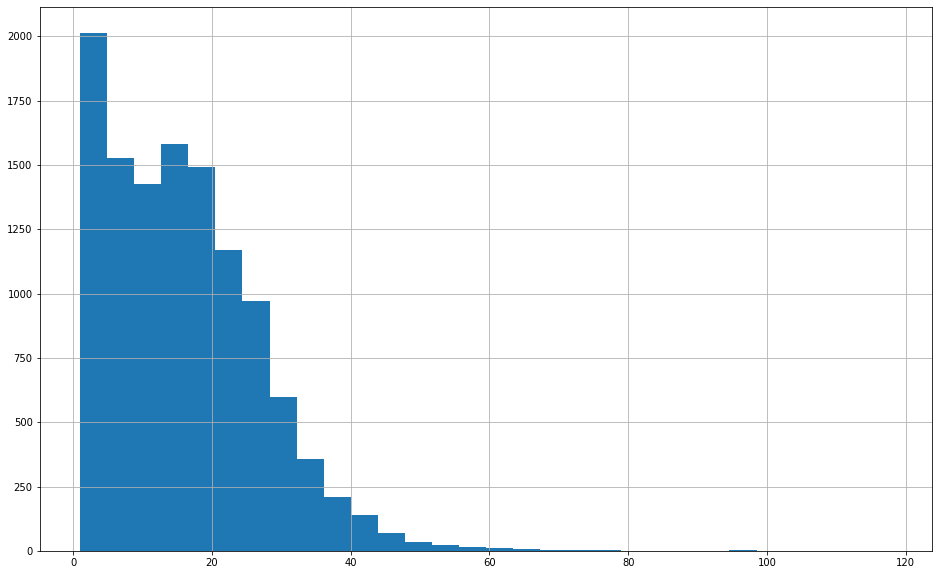

In [16]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['Text']]
pd.Series(seq_len).hist(bins = 30)

Average sequence length is 20. Posible no need to use strong deep learning algorithms.

### Define Model Architecture

In [109]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [233]:
class BERT_Arch(nn.Module):
    def __init__(self, dropout_rate=0.1, hidden_features=512):
        super(BERT_Arch, self).__init__()

        # Instantiate BERT model
        self.bert = bert

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(768, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, 2),
        )

        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)        
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        x = self.classifier(last_hidden_state_cls)
        
        x = self.softmax(x)

        return x

In [246]:
class AboutClassifier(BaseEstimator):    
    
    def __init__(self,
                 epochs = 4,
                 batch_size = 32,
                 lr = 1e-5,
                 max_length = 40,
                 dropout_rate = 0.1, 
                 hidden_features = 512,
                ):
            self.epochs = epochs
            self.batch_size = batch_size
            self.lr = lr
            self.max_length = max_length
            
            self.dropout_rate = dropout_rate
            self.hidden_features = hidden_features
            
            self.device = torch.device('cuda')                    

    def fit(self, X, y, sample_weight):  
        # Tokenize and encode sequences in the training set
        tokens_train = tokenizer.batch_encode_plus(
            X['Text'].tolist(),
            max_length = self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False
        )
        
        # Convert integer sequences to tensors
        train_seq = torch.tensor(tokens_train['input_ids'])
        train_mask = torch.tensor(tokens_train['attention_mask'])
        train_y = torch.tensor(y.tolist())
        train_w = torch.tensor(sample_weight.tolist())

        # Create dataloader        
        train_data = TensorDataset(train_seq, train_mask, train_y, train_w)
        train_dataloader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data),
                                      batch_size=self.batch_size)
        
        # Freeze BERT the parameters
        for param in bert.parameters():
            param.requires_grad = False

        self.model = BERT_Arch(dropout_rate=self.dropout_rate, hidden_features=self.hidden_features)
        self.model.to(self.device, non_blocking=True)
            
        parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        
        optimizer = torch_optim.Adam(parameters, lr=self.lr)
        criterion = nn.CrossEntropyLoss().to(self.device)
        
        self.model.train()

        # Train net
        for epoch in range(self.epochs):
            for sent_id, mask, train_y, train_w in train_dataloader:
                
                sent_id = sent_id.to(self.device, non_blocking=True)
                mask = mask.to(self.device, non_blocking=True)                
                train_y = train_y.to(self.device, non_blocking=True)
                train_w = train_w.to(self.device, non_blocking=True)
                
                optimizer.zero_grad()
                
                yhat = self.model(sent_id, mask)    
                loss = criterion(yhat, train_y)
                loss = (loss * train_w / train_w.sum()).sum()

                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), 1.0) # Tanh :(
                optimizer.step()
        return self

        
    def predict_proba(self, X):
        # Tokenize and encode sequences in the training set
        tokens_test = tokenizer.batch_encode_plus(
            X['Text'].tolist(),
            max_length = self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False
        )
        
        # Convert integer sequences to tensors
        sent_id = torch.tensor(tokens_test['input_ids'])
        mask = torch.tensor(tokens_test['attention_mask'])
        
        self.model.to(self.device, non_blocking=True)
        sent_id = sent_id.to(self.device, non_blocking=True)
        mask = mask.to(self.device, non_blocking=True)

        self.model.eval()
        yhat = self.model(sent_id, mask)
        yhat = F.softmax(yhat, dim=1)
        yhat = torch.clamp(yhat, 0, 1)
        
        yhat = yhat.cpu().detach().numpy()
        return yhat

    def predict(self, X):
        yhat = self.predict_proba(X)[:, 1]
        return yhat.round().astype(np.int32)    

In [247]:
# clf = AboutClassifier(epochs = 4)
# clf.fit(X, y, w)

AboutClassifier()

In [248]:
#       (pooler): BertPooler(
#         (dense): Linear(in_features=768, out_features=768, bias=True)
#         (activation): Tanh()
#       )
#     )
#     (dropout): Dropout(p=0.1, inplace=False)
#     (classifier): Linear(in_features=768, out_features=2, bias=True)
#   )
# )

# print (clf.model)

### Search for hyperparameters, using the statistically unreliable k-fold test. (To save time)

#### Rewriting cross_val_score because sklearn cross_val_score does not support weights.

In [81]:
from typing import Callable
from joblib import Parallel, delayed
from sklearn.base import clone

def cross_val_score(
        clf, 
        X: pd.DataFrame,
        y: pd.Series,
        cv_gen,
        sample_weight_train: np.ndarray = None,
        scoring: Callable[[np.array, np.array], float] = roc_auc_score,
        n_jobs = -1):

    # If no sample_weight then broadcast a value of 1 to all samples (full weight).
    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))
        
    if isinstance(cv_gen, list): cv_gen_list = cv_gen
    else: cv_gen_list = list(cv_gen.split(X=X, y=y))      
                        
    def calc_fold(train, test):

        if hasattr(X, 'iloc'):                
            X_train_ = X.iloc[train, :]
            X_test_ = X.iloc[test, :]

            y_train_ = y.iloc[train]
            y_test_ = y.iloc[test]
            
            w_train_ = sample_weight_train.iloc[train]

        else:
            X_train_ = X[train, :]
            X_test_ = X[test, :]

            y_train_ = y[train]
            y_test_ = y[test]
            
            w_train_ = sample_weight_train[train]

        classifier = clone(clf)
        fit = classifier.fit(X = X_train_, y = y_train_, sample_weight = w_train_)

        if scoring == roc_auc_score:
            prob = fit.predict_proba(X_test_)[:, 1]
            score = scoring(y_test_, prob)
        else:
            pred = fit.predict(X_test_)
            score = scoring(y_test_, pred)

        return score
        
    # Score model on Folds
    ret_scores = Parallel(n_jobs=n_jobs)(delayed(calc_fold)(train, test) for train, test in cv_gen_list)
        
    return np.array(ret_scores)

In [255]:
def objective(trial):

    epochs = trial.suggest_int("epochs", 1, 10)
    lr = trial.suggest_float("lr", 1e-6, 1e-3)
    
    max_length = trial.suggest_int("max_length", 20, 50, 5)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.2)

    clf = AboutClassifier(epochs=epochs, lr=lr, max_length=max_length, dropout_rate=dropout_rate)

    cv_gen = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
    cv_gen_list = list(cv_gen.split(X, y))
    
    new_score = cross_val_score(clf,
                                X=X, y=y,
                                cv_gen=cv_gen_list,
                                sample_weight_train=w,
                                scoring=f1_score,
                                n_jobs=1
                                )

    return new_score.mean()

In [256]:
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=True)
print ("Best score", study.best_value)
print ("Best params", study.best_params)

[I 2021-08-21 15:09:25,040] A new study created in memory with name: no-name-7d3d1d13-aed3-4052-b896-dfa204f6e994
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:46: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-08-21 15:13:56,277] Trial 0 finished with value: 0.47706935741177636 and parameters: {'epochs': 8, 'lr': 0.0004217957822269575, 'max_length': 20, 'dropout_rate': 0.1646834704670723}. Best is trial 0 with value: 0.47706935741177636.
[I 2021-08-21 15:22:28,245] Trial 1 finished with value: 0.5239223742860901 and parameters: {'epochs': 7, 'lr': 0.0003681366349305145, 'max_length': 50, 'dropout_rate': 0.03353944115392893}. Best is trial 1 with value: 0.5239223742860901.
[I 2021-08-21 15:28:06,367] Trial 2 finished with value: 0.5182514709825254 and parameters: {'epochs': 10, 'lr': 0.0007836110796794736, 'max_length': 20, 'dropout_rate': 0.14511569916404593}. Best is trial 1 with value: 0.5239223742860901.
[I 2021-08-21 15:30:29,999] Trial 3 finished with value: 0.48392379900885346 and parameters: {'epochs': 3, 'lr': 0.0009252696364755139, 'max_length': 30, 'dropout_rate': 0.1536113434917066}. Best is trial 1 with value: 0.5239223742860901.
[I 2021-08-21 15:39:31,426] Trial 4 finish

### Test on test data

In [257]:
clf = AboutClassifier(epochs=study.best_params['epochs'], lr=study.best_params['lr'], 
                      max_length=study.best_params['max_length'], dropout_rate=study.best_params['dropout_rate'])

In [258]:
clf.fit(X, y, w)

AboutClassifier(dropout_rate=0.04948418691513865, epochs=10,
                lr=0.0002640891687009672, max_length=45)

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      2969
           1       0.37      0.94      0.53       376

    accuracy                           0.81      3345
   macro avg       0.68      0.87      0.71      3345
weighted avg       0.92      0.81      0.84      3345

Confusion Matrix
[[2366  603]
 [  24  352]]

Target score
0.5289256198347108


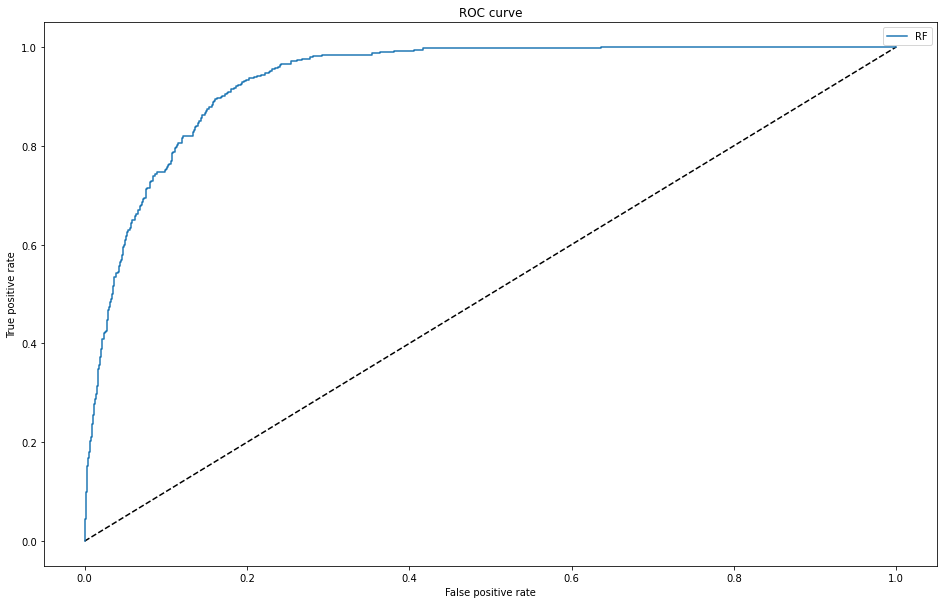

In [259]:
y_pred_rf = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Target score")
print(f1_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()